# Ebirds Data Prep

In [1]:
# # mount google drive
# from google.colab import drive
# drive.mount('/content/drive/')

In [1]:
# # required installs
!pip install geopandas shapely
!pip install --upgrade pandas numpy

  Using cached geopandas-1.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached shapely-2.1.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached pyogrio-0.11.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (5.3 kB)
  Using cached pyproj-3.7.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (31 kB)
Using cached geopandas-1.1.0-py3-none-any.whl (338 kB)
Using cached shapely-2.1.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
Using cached pyogrio-0.11.0-cp312-cp312-manylinux_2_28_x86_64.whl (27.7 MB)
Using cached pyproj-3.7.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [geopandas]/4 [geopandas]
  Using cached pandas-2.3.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (91 kB)
  Using cached numpy-2.3.1-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (62 kB)
Using cached pandas-2.3.0-cp312-cp312-manylinux_2_17_x86_6

In [2]:
!pip install geopy

  Using cached geopy-2.4.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached geographiclib-2.0-py3-none-any.whl.metadata (1.4 kB)
Using cached geopy-2.4.1-py3-none-any.whl (125 kB)
Using cached geographiclib-2.0-py3-none-any.whl (40 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [geopy]


In [3]:
# required imports
import pandas as pd
import numpy as np
import geopandas as gpd
import zipfile
import os
import logging
import time
import gc
import pyarrow as pa
import pyarrow.parquet as pq
from pathlib import Path
from datetime import datetime
from shapely.geometry import Point, LineString
from shapely.ops import nearest_points
from typing import Optional
from geopy.distance import geodesic
from typing import Optional, List, Dict, Any

import warnings
warnings.filterwarnings('ignore')

scipy library requires an older numpy version. Unfortunately, using the old numpy inhibits the use of pandas.  Run the following only if calculating

In [4]:
# ## Run this first and restart the notebook - resolves scipy-numpy discrepency ###
# !pip uninstall -y numpy scipy
# !pip install numpy==1.24.4 scipy==1.10.1

# # Running this cell will require you to restart the session.

In [5]:
# # imports for
# from scipy.spatial.distance import cdist

In [6]:
import boto3
import pandas as pd
import io
from botocore.exceptions import ClientError
from shapely.geometry import Point, Polygon
import math
import numpy as np
import pandas as pd
from typing import Optional, Union, Tuple
import json
from ipywidgets import interact, FloatSlider, Layout
import ipywidgets as widgets
from shapely.vectorized import contains
import s3fs

### Dataset check

In [29]:
# Initialize boto3 session and get credentials
session = boto3.Session()
credentials = session.get_credentials()

# Initialize S3 filesystem with boto3 credentials
s3 = s3fs.S3FileSystem(
    key=credentials.access_key,
    secret=credentials.secret_key,
    token=credentials.token,  # This will be included if using temporary credentials
    anon=False
)
# Read the parquet file
VA_birds = pd.read_parquet('s3://birdsbucker/ebirds/ebd_US-VA_smp_relApr-2025_filtered.parquet', filesystem=s3)
ME_birds = pd.read_parquet('s3://birdsbucker/ebirds/polygon_filtered_ME_data.parquet', filesystem=s3)

print( "VA birds", len(VA_birds))
print( "ME birds", len(ME_birds))

VA birds 71870
ME birds 908976


In [30]:
##Selecting relevant columns
VA_birds=VA_birds[['OBSERVATION COUNT', 'STATE CODE', 'LOCALITY TYPE', 'LATITUDE',
       'LONGITUDE', 'OBSERVATION DATE', 'TIME OBSERVATIONS STARTED']]


In [33]:
VA_birds['OBSERVATION DATE'] = pd.to_datetime(VA_birds['OBSERVATION DATE'])

# Filter for years 2020-2023
VA_birds = VA_birds[
    (VA_birds['OBSERVATION DATE'].dt.year >= 2020) & 
    (VA_birds['OBSERVATION DATE'].dt.year <= 2023)
]

VA_birds.tail()

,OBSERVATION COUNT,STATE CODE,LOCALITY TYPE,LATITUDE,LONGITUDE,OBSERVATION DATE,TIME OBSERVATIONS STARTED
60909,5,US-VA,P,38.1817130,-77.5166560,2023-12-24,10:57:00
60910,2,US-VA,P,38.1863970,-77.4946690,2023-12-30,11:54:00
60911,2,US-VA,P,38.1862390,-77.4946000,2023-12-09,09:07:00
60912,1,US-VA,H,38.1829925,-77.5173989,2023-12-24,11:08:00
60913,1,US-VA,P,38.1817130,-77.5166560,2023-12-24,10:57:00


In [7]:
# # Basic information about both datasets
# print("=== Virginia Birds Dataset ===")
# print("\nInfo:")
# print(VA_birds.info())
# print("\nFirst few rows:")
# print(VA_birds.head())
# print("\nBasic statistics:")
# print(VA_birds.describe())
# print("\nMissing values:")
# print(VA_birds.isnull().sum())

# print("\n=== Maine Birds Dataset ===")
# print("\nInfo:")
# print(ME_birds.info())
# print("\nFirst few rows:")
# print(ME_birds.head())
# print("\nBasic statistics:")
# print(ME_birds.describe())
# print("\nMissing values:")
# print(ME_birds.isnull().sum())

# # Check for duplicates
# print("\nDuplicates in VA_birds:", VA_birds.duplicated().sum())
# print("Duplicates in ME_birds:", ME_birds.duplicated().sum())

In [35]:
birds=pd.concat([VA_birds, ME_birds], axis=0, ignore_index=True)
len(birds)

952074

In [36]:
import boto3
import pyarrow as pa
import pyarrow.parquet as pq
from datetime import datetime

# First, let's check the data types of your DataFrame
print("Original data types:")
print(birds.dtypes)

# Convert the OBSERVATION DATE column to datetime if it isn't already
try:
    birds['OBSERVATION DATE'] = pd.to_datetime(birds['OBSERVATION DATE'])
    print("\nData types after conversion:")
    print(birds.dtypes)
except Exception as e:
    print(f"Error converting date: {str(e)}")

# Create a timestamp for the filename
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
file_name = f'combined_birds_{timestamp}.parquet'
s3_path = f's3://birdsbucker/ebirds/{file_name}'

try:
    # Save to parquet using pandas with explicit date handling
    birds.to_parquet(
        s3_path,
        engine='pyarrow',
        compression='snappy',
        index=False,
        # Specify the date format if needed
        # coerce_timestamps='ms'  # Uncomment if you get timestamp-related errors
    )
    print(f"Successfully saved parquet file to {s3_path}")
    
except Exception as e:
    print(f"Error saving to S3: {str(e)}")
    
    # If the above fails, try with additional data type handling
    try:
        # Convert all timestamp columns to datetime64[ns]
        for col in birds.select_dtypes(include=['datetime64']).columns:
            birds[col] = birds[col].astype('datetime64[ns]')
            
        birds.to_parquet(
            s3_path,
            engine='pyarrow',
            compression='snappy',
            index=False
        )
        print(f"Successfully saved parquet file after type conversion to {s3_path}")
    except Exception as e2:
        print(f"Second attempt failed: {str(e2)}")



Original data types:
OBSERVATION COUNT                    object
STATE CODE                           object
LOCALITY TYPE                        object
LATITUDE                             object
LONGITUDE                            object
OBSERVATION DATE             datetime64[ns]
TIME OBSERVATIONS STARTED            object
dtype: object

Data types after conversion:
OBSERVATION COUNT                    object
STATE CODE                           object
LOCALITY TYPE                        object
LATITUDE                             object
LONGITUDE                            object
OBSERVATION DATE             datetime64[ns]
TIME OBSERVATIONS STARTED            object
dtype: object
Successfully saved parquet file to s3://birdsbucker/ebirds/combined_birds_20250624_030647.parquet


In [37]:
# Verify the file was created (optional)
try:
    s3 = boto3.client('s3')
    response = s3.list_objects_v2(
        Bucket='birdsbucker',
        Prefix='ebirds/'
    )
    print("\nFiles in destination:")
    for obj in response.get('Contents', []):
        print(f"- {obj['Key']}")
        
except Exception as e:
    print(f"Error verifying file: {str(e)}")


Files in destination:
- ebirds/
- ebirds/combined_birds_20250623_233431.parquet
- ebirds/combined_birds_20250624_030647.parquet
- ebirds/ebd_US-ME_smp_relMay-2025.parquet
- ebirds/ebd_US-ME_smp_relMay-2025.zip
- ebirds/ebd_US-VA_smp_relApr-2025.parquet
- ebirds/ebd_US-VA_smp_relApr-2025_filtered.parquet
- ebirds/ebd_US-VA_smp_relApr-2025_sampling.txt
- ebirds/polygon_filtered_ME_data.parquet


### Calculates distance between bird observation point to I95 - nearest point on a line between the two nearest I95 geo coordinates.
Adds 'i95_distance' to Ebirds dataset.

In [14]:
# # Read in Ebird data if not too large or loa
# birds = pd.read_csv('DATASET', nrows=1000)
# print(birds.shape)
# print(birds.columns)
# print(birds.head())

In [38]:
s3_client = boto3.client('s3')
        
# Get the object from S3
response = s3_client.get_object(Bucket='birdsbucker', Key='trafficVolume/i95_coordinates.csv')

# Read the CSV content with additional options
i95_coordinates = pd.read_csv(io.BytesIO(response['Body'].read()))

In [20]:
# i95_coordinates = pd.read_csv('i95_coordinates.csv')
print(i95_coordinates.shape)
print(i95_coordinates.columns)
print(i95_coordinates.head())

(55654, 10)
Index(['Way_ID', 'Segment_Number', 'Point_Order', 'Longitude', 'Latitude',
       'Highway_Type', 'Route_Ref', 'Max_Speed', 'Combined_Path',
       'Overall_Sequence'],
      dtype='object')
     Way_ID  Segment_Number  Point_Order  Longitude   Latitude Highway_Type  \
0  way/2059               0            0 -77.451046  37.680565     motorway   
1  way/2059               0            1 -77.451240  37.681075     motorway   
2  way/2059               0            2 -77.451470  37.681770     motorway   
3  way/2059               0            3 -77.451679  37.682531     motorway   
4  way/2059               0            4 -77.451867  37.683562     motorway   

  Route_Ref Max_Speed Combined_Path  Overall_Sequence  
0      I 95    65 mph           0_0                 0  
1      I 95    65 mph           0_1                 1  
2      I 95    65 mph           0_2                 2  
3      I 95    65 mph           0_3                 3  
4      I 95    65 mph           0_4       

In [39]:
i95_sorted = i95_coordinates.sort_values(['Overall_Sequence'])
i95_coords = list(zip(i95_sorted['Latitude'], i95_sorted['Longitude']))

In [13]:
!pip install folium

  Using cached folium-0.20.0-py2.py3-none-any.whl.metadata (4.2 kB)
  Using cached branca-0.8.1-py3-none-any.whl.metadata (1.5 kB)
Using cached folium-0.20.0-py2.py3-none-any.whl (113 kB)
Using cached branca-0.8.1-py3-none-any.whl (26 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [folium]


#### Graph i95 Coordinates

In [ ]:
import folium

# Create a base map centered on the mean coordinates
center_lat = i95_coordinates['Latitude'].mean()
center_lon = i95_coordinates['Longitude'].mean()
m = folium.Map(location=[center_lat, center_lon], 
               zoom_start=8,
               tiles='cartodbpositron')  # Different map style

# Add markers for each point
for idx, row in i95_coordinates.iterrows():
    # You can customize the color based on some condition
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=6,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        popup=folium.Popup(f"Point {idx}", parse_html=True),
        tooltip=f"Click for more info"
    ).add_to(m)

# Add a title
title_html = '''
             <h3 align="center" style="font-size:16px">
             <b>I-95 Coordinates</b>
             </h3>
             '''
m.get_root().html.add_child(folium.Element(title_html))
# m
m.save('i95_route points.html')

#### Functions for Distance

In [40]:

# import logging
# import pandas as pd
# import geopandas as gpd
# import numpy as np
# from shapely.geometry import Point, LineString
# import pyarrow as pa
# import pyarrow.parquet as pq
# from pathlib import Path
# import gc
# from typing import Optional, List, Dict, Any

### Modify file names before running ###
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class OptimizedParquetBatchProcessor:
    """
    Heavily optimized processor for large parquet files using GeoPandas, spatial indexing,
    and vectorized operations with memory-efficient parquet streaming.
    Expected 10-100x performance improvement with better memory management.
    """

    def __init__(self,
                 input_file: str = "cleaned_ebird_file.pq",
                 output_file: str = "new_file.pq",
                 batch_size: int = 50000,
                 distance_threshold: Optional[float] = None,
                 i95_coords: Optional[List] = None,
                #  columns_to_keep: Optional[List[str]] = None,
                 use_compression: str = 'snappy'):

        self.input_file = Path(input_file)
        self.output_file = Path(output_file)
        self.batch_size = batch_size
        self.distance_threshold = distance_threshold
        # self.columns_to_keep = columns_to_keep
        self.use_compression = use_compression

        # Validate input file
        if not self.input_file.exists():
            raise FileNotFoundError(f"Input file not found: {input_file}")

        # Setup parquet file metadata
        self._setup_parquet_metadata()

        # Pre-process I-95 coordinates into optimized spatial structures
        self._setup_highway_geometry(i95_coords)

        # Statistics tracking
        self.total_rows_processed = 0
        self.total_rows_saved = 0
        self.batch_count = 0
        self.total_file_size = 0

    def _setup_parquet_metadata(self):
        """Get parquet file metadata for optimization"""
        try:
            # Read parquet metadata
            parquet_file = pq.ParquetFile(self.input_file)
            self.parquet_metadata = parquet_file.metadata
            self.parquet_schema = parquet_file.schema
            self.total_rows = self.parquet_metadata.num_rows

            logger.info(f"Parquet file info:")
            logger.info(f"  Total rows: {self.total_rows:,}")
            logger.info(f"  Number of row groups: {self.parquet_metadata.num_row_groups}")
            logger.info(f"  Columns: {len(self.parquet_schema)}")

            # Get file size
            self.total_file_size = self.input_file.stat().st_size / (1024**3)  # GB
            logger.info(f"  File size: {self.total_file_size:.2f} GB")

        except Exception as e:
            logger.error(f"Error reading parquet metadata: {e}")
            raise

    def _setup_highway_geometry(self, i95_coords):
        """Convert I-95 coordinates to optimized spatial structures"""
        if not i95_coords:
            raise ValueError("I-95 coordinates must be provided")

        logger.info("Setting up highway geometry with spatial indexing...")

        # Create LineString geometry from coordinates
        # i95_coords are (lat,lon) but LineString expects (lon,lat), so swap them
        self.highway_line = LineString([(lon, lat) for lat, lon in i95_coords])

        # Create GeoDataFrame for the highway with spatial index
        highway_gdf = gpd.GeoDataFrame([1], geometry=[self.highway_line], crs='EPSG:4326')

        # Convert to projected CRS for accurate distance calculations (UTM Zone 18N)
        self.highway_gdf_projected = highway_gdf.to_crs('EPSG:32618')
        self.highway_line_projected = self.highway_gdf_projected.geometry.iloc[0]

        logger.info("Highway geometry setup complete")

    def calculate_distances_vectorized(self, obs_gdf: gpd.GeoDataFrame) -> np.ndarray:
        """
        Vectorized distance calculation using GeoPandas
        This is the key optimization - processes all points at once
        """
        # Project observations to same CRS as highway (UTM Zone 18N)
        obs_projected = obs_gdf.to_crs('EPSG:32618')

        # Vectorized distance calculation to highway line
        distances_meters = obs_projected.geometry.distance(self.highway_line_projected)

        # Convert meters to miles
        distances_miles = distances_meters * 0.000621371

        return distances_miles.values

    def process_batch_optimized(self, batch_df: pd.DataFrame) -> pd.DataFrame:
        """Optimized batch processing using vectorized operations"""

        # Early return if empty batch
        if batch_df.empty:
            return pd.DataFrame()

        # Filter out rows with invalid coordinates early
        valid_coords = batch_df.dropna(subset=['LATITUDE', 'LONGITUDE'])

        if len(valid_coords) == 0:
            logger.warning("No valid coordinates in batch")
            return pd.DataFrame()

        # Convert to numeric and filter realistic coordinate ranges
        valid_coords = valid_coords.copy()

        # Use more efficient numeric conversion
        coord_cols = ['LATITUDE', 'LONGITUDE']
        for col in coord_cols:
            if valid_coords[col].dtype == 'object':
                valid_coords[col] = pd.to_numeric(valid_coords[col], errors='coerce')

        # Filter to reasonable coordinate bounds (roughly continental US)
        coord_filter = (
            (valid_coords['LATITUDE'].between(24, 50)) &
            (valid_coords['LONGITUDE'].between(-130, -65))
        )
        valid_coords = valid_coords[coord_filter]

        if len(valid_coords) == 0:
            logger.warning("No valid coordinates after filtering")
            return pd.DataFrame()

        # Create GeoDataFrame from observations
        geometry = gpd.points_from_xy(valid_coords['LONGITUDE'], valid_coords['LATITUDE'])
        obs_gdf = gpd.GeoDataFrame(valid_coords, geometry=geometry, crs='EPSG:4326')

        # Calculate distances using vectorized operation
        distances = self.calculate_distances_vectorized(obs_gdf)

        # Add distances to dataframe
        result_df = valid_coords.copy()
        result_df['i95_distance'] = distances

        # Apply distance filter if specified
        if self.distance_threshold is not None:
            result_df = result_df[result_df['i95_distance'] <= self.distance_threshold]

        # # Select only specified columns if provided
        # if self.columns_to_keep:
        #     available_cols = [col for col in self.columns_to_keep + ['i95_distance']
        #                     if col in result_df.columns]
        #     result_df = result_df[available_cols]

        return result_df

    def _process_one_batch(self, batch_df: pd.DataFrame) -> pd.DataFrame:
        """Process a single batch with logging and memory management"""
        self.batch_count += 1
        self.total_rows_processed += len(batch_df)

        if self.batch_count % 10 == 0:  # Log every 10th batch to reduce noise
            progress = (self.total_rows_processed / self.total_rows) * 100
            logger.info(f"Processing batch {self.batch_count} ({progress:.1f}% complete) "
                       f"with {len(batch_df)} rows")

        processed_batch = self.process_batch_optimized(batch_df)
        self.total_rows_saved += len(processed_batch)

        # Force garbage collection periodically
        if self.batch_count % 50 == 0:
            gc.collect()

        return processed_batch

    def _read_parquet_in_batches(self):
        """Generator to read parquet file in batches efficiently"""
        try:
            # Use pyarrow for more efficient reading
            parquet_file = pq.ParquetFile(self.input_file)

            # Read in batches using row groups when possible
            for batch in parquet_file.iter_batches(batch_size=self.batch_size):
                # Convert to pandas DataFrame
                df = batch.to_pandas()
                yield df

        except Exception as e:
            logger.error(f"Error reading parquet in batches: {e}")
            # Fallback to pandas chunking
            logger.info("Falling back to pandas chunking...")
            try:
                # Read the entire file and chunk it manually since pandas doesn't support chunksize for parquet
                df = pd.read_parquet(self.input_file)
                for i in range(0, len(df), self.batch_size):
                    yield df.iloc[i:i+self.batch_size]
                del df  # Free memory
            except Exception as e2:
                logger.error(f"Fallback also failed: {e2}")
                raise

    def _write_parquet_batch(self, df: pd.DataFrame, is_first_batch: bool = False):
        """Write batch to parquet file efficiently"""
        if df.empty:
            return

        # Convert to Arrow Table for efficient writing
        table = pa.Table.from_pandas(df)

        if is_first_batch:
            # Create new file with compatible parameters
            writer = pq.ParquetWriter(
                self.output_file,
                table.schema,
                compression=self.use_compression,
                use_dictionary=True  # Enable dictionary encoding
            )
            self._parquet_writer = writer

        # Write the batch
        self._parquet_writer.write_table(table)

    def run_pipeline(self) -> Dict[str, Any]:
        """Run the complete optimized pipeline for parquet files"""
        logger.info(f"Starting optimized parquet pipeline: {self.input_file}")
        logger.info(f"Batch size: {self.batch_size:,}")
        logger.info(f"Distance threshold: {self.distance_threshold}")
        logger.info(f"Expected batches: {(self.total_rows // self.batch_size) + 1}")

        start_time = pd.Timestamp.now()
        first_batch = True

        try:
            # Process file in batches
            for batch_df in self._read_parquet_in_batches():
                processed_batch = self._process_one_batch(batch_df)

                if not processed_batch.empty:
                    self._write_parquet_batch(processed_batch, is_first_batch=first_batch)
                    first_batch = False

            # Close the parquet writer
            if hasattr(self, '_parquet_writer'):
                self._parquet_writer.close()
                logger.info(f"Saved {self.total_rows_saved:,} rows to {self.output_file}")
            else:
                logger.warning("No data to save")

        except Exception as e:
            logger.error(f"Pipeline error: {str(e)}")
            # Clean up partial file
            if self.output_file.exists():
                self.output_file.unlink()
            raise

        finally:
            # Cleanup
            if hasattr(self, '_parquet_writer'):
                try:
                    self._parquet_writer.close()
                except:
                    pass

        end_time = pd.Timestamp.now()
        processing_time = (end_time - start_time).total_seconds()

        # Calculate statistics
        stats = {
            'total_rows_processed': self.total_rows_processed,
            'total_rows_saved': self.total_rows_saved,
            'total_batches': self.batch_count,
            'input_file': str(self.input_file),
            'output_file': str(self.output_file),
            'input_file_size_gb': self.total_file_size,
            'output_file_size_gb': self.output_file.stat().st_size / (1024**3) if self.output_file.exists() else 0,
            'processing_time_seconds': processing_time,
            'processing_time_formatted': str(pd.Timedelta(seconds=processing_time)),
            'rows_per_second': self.total_rows_processed / processing_time if processing_time > 0 else 0,
            'filter_efficiency_percent': (self.total_rows_saved / self.total_rows_processed * 100)
                                        if self.total_rows_processed > 0 else 0,
            'compression_ratio': (self.total_file_size / (self.output_file.stat().st_size / (1024**3)))
                               if self.output_file.exists() and self.output_file.stat().st_size > 0 else 0
        }

        logger.info("Optimized parquet pipeline completed!")
        logger.info(f"Processing time: {stats['processing_time_formatted']}")
        logger.info(f"Rows per second: {stats['rows_per_second']:,.0f}")
        logger.info(f"Filter efficiency: {stats['filter_efficiency_percent']:.2f}%")
        logger.info(f"Compression ratio: {stats['compression_ratio']:.2f}x")

        return stats

# # Example usage
# if __name__ == "__main__":

#     # Initialize processor
#     processor = OptimizedParquetBatchProcessor(
#         input_file="cleaned_ebird_file.pq",
#         output_file="filtered_ebird_i95.pq",
#         batch_size=50000,
#         distance_threshold=10.0,  # 10 miles
#         i95_coords=i95_coords,
#         use_compression='snappy'
#     )

#     # Run the pipeline
#     results = processor.run_pipeline()
#     print(f"Processing completed: {results}")

In [41]:
### Modify parameters ###
# Example usage
if __name__ == "__main__":
    import s3fs
    import boto3
    
    # S3 configuration
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    file_name = f'ebird_i95_{timestamp}.parquet'
    s3_bucket = "birdsbucker"
    s3_output_path = f'Pipeline_Outputs/processed_birds/{file_name}'
    s3_output_uri = f"s3://{s3_bucket}/{s3_output_path}"
    
    # Initialize S3 filesystem
    s3 = s3fs.S3FileSystem()
    
    # First save the DataFrame to a temporary parquet file
    temp_input_file = "temp_birds_input.parquet"
    temp_output_file = "temp_output.parquet"
    birds.to_parquet(temp_input_file, compression='snappy')

    try:
        # Initialize processor with local temporary output
        processor = OptimizedParquetBatchProcessor(
            input_file=temp_input_file,
            output_file=temp_output_file,  # Use local temporary file
            batch_size=50000,
            distance_threshold=10.0,  # in miles
            i95_coords=i95_coords,
            use_compression='snappy'
        )

        # Run the pipeline
        results = processor.run_pipeline()
        
        # Upload the processed file to S3
        s3.put(temp_output_file, s3_output_uri)
        
        print(f"Processing completed and saved to: {s3_output_uri}")
        print(f"Results: {results}")
    
    finally:
        # Clean up temporary files
        import os
        for temp_file in [temp_input_file, temp_output_file]:
            if os.path.exists(temp_file):
                os.remove(temp_file)
                print(f"Cleaned up temporary file: {temp_file}")

2025-06-24 03:07:44,954 - INFO - Parquet file info:
2025-06-24 03:07:44,955 - INFO -   Total rows: 952,074
2025-06-24 03:07:44,956 - INFO -   Number of row groups: 1
2025-06-24 03:07:44,956 - INFO -   Columns: 7
2025-06-24 03:07:44,957 - INFO -   File size: 0.01 GB
2025-06-24 03:07:44,958 - INFO - Setting up highway geometry with spatial indexing...
2025-06-24 03:07:45,074 - INFO - Highway geometry setup complete
2025-06-24 03:07:45,075 - INFO - Starting optimized parquet pipeline: temp_birds_input.parquet
2025-06-24 03:07:45,076 - INFO - Batch size: 50,000
2025-06-24 03:07:45,076 - INFO - Distance threshold: 10.0
2025-06-24 03:07:45,077 - INFO - Expected batches: 20
2025-06-24 03:11:39,186 - INFO - Processing batch 10 (52.5% complete) with 50000 rows
2025-06-24 03:15:59,453 - INFO - Processing batch 20 (100.0% complete) with 2074 rows
2025-06-24 03:16:00,635 - INFO - Saved 952,074 rows to temp_output.parquet
2025-06-24 03:16:00,638 - INFO - Optimized parquet pipeline completed!
2025-0

Processing completed and saved to: s3://birdsbucker/Pipeline_Outputs/processed_birds/ebird_i95_20250624_030744.parquet
Results: {'total_rows_processed': 952074, 'total_rows_saved': 952074, 'total_batches': 20, 'input_file': 'temp_birds_input.parquet', 'output_file': 'temp_output.parquet', 'input_file_size_gb': 0, 'output_file_size_gb': 0.007160264998674393, 'processing_time_seconds': 495.556781, 'processing_time_formatted': '0 days 00:08:15.556781', 'rows_per_second': 1921.2208096088993, 'filter_efficiency_percent': 100.0, 'compression_ratio': 0.0}
Cleaned up temporary file: temp_birds_input.parquet
Cleaned up temporary file: temp_output.parquet


In [42]:
# ebirds/combined_birds_20250623_233431.parquet
s3_path = 's3://birdsbucker/Pipeline_Outputs/processed_birds/ebird_i95_20250624_030744.parquet'

try:
    # Read parquet file directly from S3
    birds = pd.read_parquet(s3_path)
    
    # Display basic information about the DataFrame
    print("DataFrame Info:")
    print(birds.info())
    
    print("\nFirst few rows:")
    print(birds.head())
    
    print("\nShape of DataFrame:", birds.shape)
    
    print("\nColumn names:")
    print(birds.columns.tolist())
    
except Exception as e:
    print(f"Error reading parquet file: {str(e)}")

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 952074 entries, 0 to 952073
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   OBSERVATION COUNT          952074 non-null  object        
 1   STATE CODE                 952074 non-null  object        
 2   LOCALITY TYPE              952074 non-null  object        
 3   LATITUDE                   952074 non-null  float64       
 4   LONGITUDE                  952074 non-null  float64       
 5   OBSERVATION DATE           952074 non-null  datetime64[ns]
 6   TIME OBSERVATIONS STARTED  952074 non-null  object        
 7   i95_distance               952074 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 58.1+ MB
None

First few rows:
  OBSERVATION COUNT STATE CODE LOCALITY TYPE   LATITUDE  LONGITUDE  \
0                 2      US-VA             H  38.146335 -77.443370   


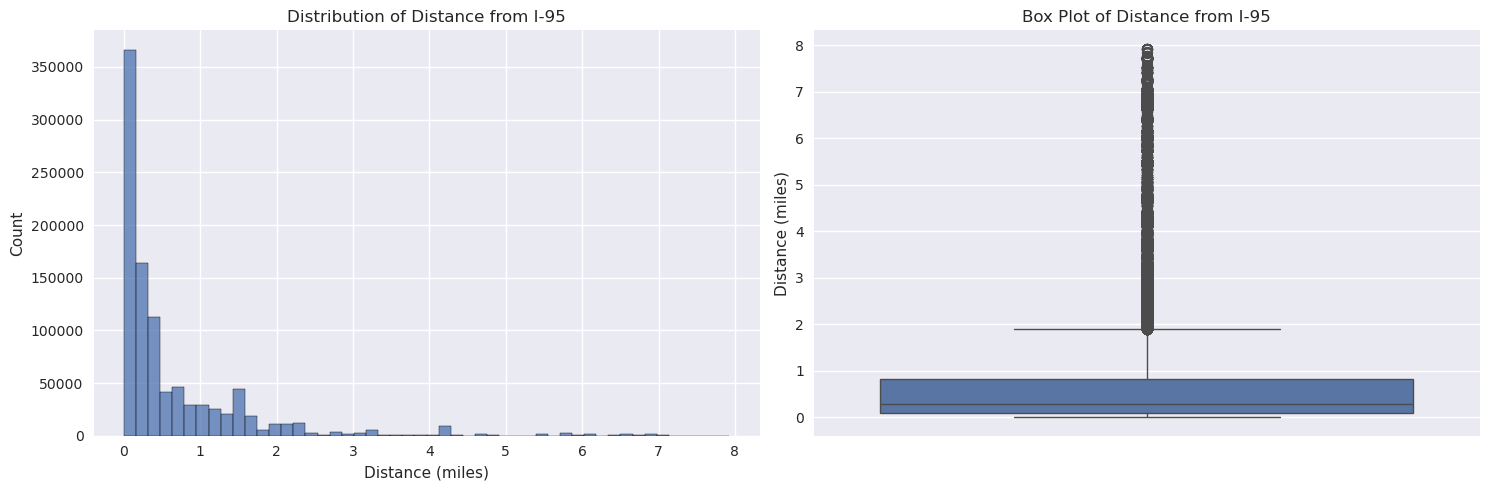


Summary Statistics for i95_distance:
count    9.808460e+05
mean     6.536856e-01
std      9.965639e-01
min      6.954758e-07
25%      9.411252e-02
50%      2.785054e-01
75%      8.162195e-01
max      7.928135e+00
Name: i95_distance, dtype: float64

Percentage of observations by distance range:
0-1 miles: 78.26%
1-5 miles: 20.50%
5-10 miles: 1.24%
10-20 miles: 0.00%
20+ miles: 0.00%


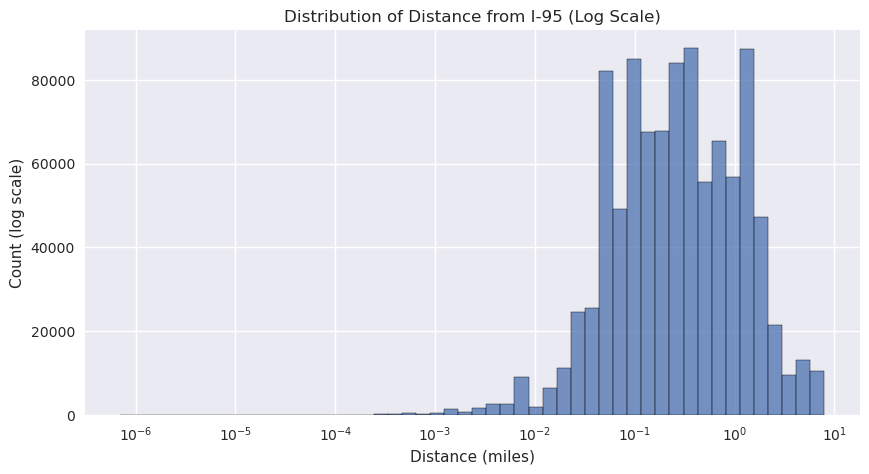

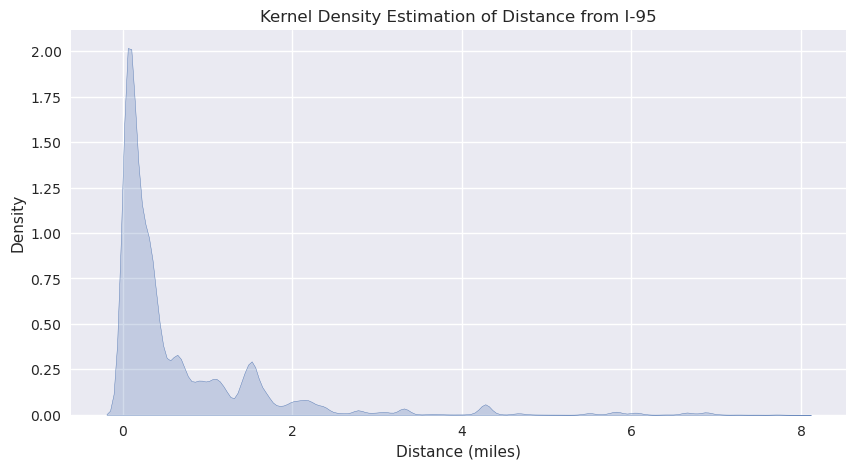


Skewness: 3.2483718153196772
Kurtosis: 13.430286931093315


In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for better visualization
plt.style.use('seaborn-v0_8')  # Updated style name
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
sns.histplot(data=birds, 
            x='i95_distance',
            bins=50,
            ax=ax1)
ax1.set_title('Distribution of Distance from I-95')
ax1.set_xlabel('Distance (miles)')
ax1.set_ylabel('Count')

# Box plot
sns.boxplot(y=birds['i95_distance'], ax=ax2)
ax2.set_title('Box Plot of Distance from I-95')
ax2.set_ylabel('Distance (miles)')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics for i95_distance:")
print(birds['i95_distance'].describe())

# Calculate percentage of observations within different distance ranges
ranges = [0, 1, 5, 10, 20, float('inf')]
labels = ['0-1 miles', '1-5 miles', '5-10 miles', '10-20 miles', '20+ miles']

print("\nPercentage of observations by distance range:")
for i in range(len(ranges)-1):
    mask = (birds['i95_distance'] >= ranges[i]) & (birds['i95_distance'] < ranges[i+1])
    percentage = (mask.sum() / len(birds)) * 100
    print(f"{labels[i]}: {percentage:.2f}%")

# Additional visualization with log scale for better visibility of distribution
plt.figure(figsize=(10, 5))
sns.histplot(data=birds, 
            x='i95_distance',
            bins=50,
            log_scale=True)
plt.title('Distribution of Distance from I-95 (Log Scale)')
plt.xlabel('Distance (miles)')
plt.ylabel('Count (log scale)')
plt.show()

# KDE plot for smooth distribution
plt.figure(figsize=(10, 5))
sns.kdeplot(data=birds['i95_distance'], fill=True)
plt.title('Kernel Density Estimation of Distance from I-95')
plt.xlabel('Distance (miles)')
plt.ylabel('Density')
plt.show()

# Print additional statistics
print("\nSkewness:", birds['i95_distance'].skew())
print("Kurtosis:", birds['i95_distance'].kurtosis())

### Read stations data

In [43]:
import pandas as pd
import boto3
import s3fs

# Define the S3 path
s3_path = 's3://birdsbucker/trafficVolume/I95_stations_master.csv'

try:
    # Read CSV directly from S3
    traffic_stations = pd.read_csv(s3_path)
    
    # Display basic information about the DataFrame
    print("DataFrame Info:")
    print(traffic_stations.info())
    
    print("\nFirst few rows:")
    print(traffic_stations.head())
    
    print("\nShape of DataFrame:", traffic_stations.shape)
    
except Exception as e:
    print(f"Error reading CSV file: {str(e)}")

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892 entries, 0 to 891
Data columns (total 42 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   record_type           892 non-null    object 
 1   state_code            892 non-null    int64  
 2   station_id            892 non-null    object 
 3   travel_dir            892 non-null    int64  
 4   travel_lane           892 non-null    int64  
 5   year_record           892 non-null    int64  
 6   f_system              892 non-null    object 
 7   num_lanes             892 non-null    int64  
 8   sample_type_volume    892 non-null    object 
 9   num_lanes_volume      892 non-null    int64  
 10  method_volume         892 non-null    int64  
 11  sample_type_class     892 non-null    object 
 12  num_lanes_class       892 non-null    int64  
 13  method_class          892 non-null    int64  
 14  algorithm_volume      892 non-null    object 
 15  num_cla

In [44]:
traffic_stations=traffic_stations[['station_id', 'longitude', 'latitude', 'state']]
traffic_stations.head()

,station_id,longitude,latitude,state
0,001295,-77.01963,38.81420,DC
1,001295,-77.01963,38.81420,DC
2,001295,-77.01963,38.81420,DC
3,001295,-77.01963,38.81420,DC
4,002295,-77.01858,38.81726,DC


In [45]:
# Filter for ME and VA stations
me_va_stations = traffic_stations[traffic_stations['state'].isin(['ME', 'VA'])]
me_va_stations.head()

,station_id,longitude,latitude,state
169,040056,-77.35887,37.117950,VA
170,040285,-77.44490,37.624090,VA
171,040298,-77.40591,37.374440,VA
172,040046,-77.36514,37.616574,VA
173,040305,-77.46772,37.593660,VA


#### Filter stations within polygons 

In [46]:
import pandas as pd
import geopandas as gpd
import s3fs

# Initialize S3 filesystem
s3 = s3fs.S3FileSystem()

# Read polygon files from S3
s3_polygon_path = 's3://birdsbucker/area_polygons/'

# List all polygon files in the directory
polygon_files = s3.ls(s3_polygon_path)

# Create empty GeoDataFrame to store all polygons
all_polygons = gpd.GeoDataFrame()

# Read and combine all polygon files
for file in polygon_files:
    # Create a proper S3 path
    s3_path = f's3://{file}'
    
    try:
        # Read the file using geopandas with s3fs
        polygon = gpd.read_file(f"zip+s3://{file}" if file.endswith('.zip') 
                              else f"s3://{file}")
        
        # Concatenate with existing polygons
        all_polygons = pd.concat([all_polygons, polygon], ignore_index=True)
        print(f"Successfully read: {file}")
    except Exception as e:
        print(f"Error reading {file}: {str(e)}")
        continue

if len(all_polygons) == 0:
    print("No polygons were successfully loaded.")
    import sys
    sys.exit()

# Convert traffic stations to GeoDataFrame
stations_gdf = gpd.GeoDataFrame(
    me_va_stations, 
    geometry=gpd.points_from_xy(me_va_stations.longitude, me_va_stations.latitude),
    crs="EPSG:4326"  # WGS 84 coordinate system
)

# Make sure both GeoDataFrames use the same CRS
all_polygons = all_polygons.to_crs(stations_gdf.crs)

# Spatial join to find stations within polygons
stations_in_polygons = gpd.sjoin(stations_gdf, all_polygons, how='inner', predicate='within')

print("Original number of ME/VA stations:", len(me_va_stations))
print("Number of stations within polygons:", len(stations_in_polygons))

# Display the filtered stations
print("\nFiltered stations:")
print(stations_in_polygons[['state', 'station_id', 'latitude', 'longitude']].head())

# Optional: Create a map visualization
try:
    import folium
    
    # Create a map centered on the mean coordinates
    m = folium.Map(
        location=[stations_in_polygons.latitude.mean(), 
                 stations_in_polygons.longitude.mean()],
        zoom_start=6
    )
    
    # Add stations as markers
    for idx, row in stations_in_polygons.iterrows():
        folium.CircleMarker(
            location=[row.latitude, row.longitude],
            radius=5,
            popup=f"Station ID: {row.station_id}\nState: {row.state}",
            color='red',
            fill=True
        ).add_to(m)
    
    # Add polygons
    folium.GeoJson(all_polygons).add_to(m)
    
    # Display the map
    display(m)
    
except ImportError:
    print("Folium not installed. Skipping map visualization.")

# Print the file types found in the directory
print("\nFiles found in directory:")
for file in polygon_files:
    print(f"- {file}")

Error reading birdsbucker/area_polygons/: '/vsis3/birdsbucker/area_polygons/' not recognized as being in a supported file format.; It might help to specify the correct driver explicitly by prefixing the file path with '<DRIVER>:', e.g. 'CSV:path'.
Successfully read: birdsbucker/area_polygons/ME_polygon.json
Successfully read: birdsbucker/area_polygons/VA_polygon.json
Error reading birdsbucker/area_polygons/stations_in_polygons.parquet: '/vsis3/birdsbucker/area_polygons/stations_in_polygons.parquet' not recognized as being in a supported file format.; It might help to specify the correct driver explicitly by prefixing the file path with '<DRIVER>:', e.g. 'CSV:path'.
Original number of ME/VA stations: 375
Number of stations within polygons: 70

Filtered stations:
    state station_id  latitude  longitude
175    VA     040099  37.70964  -77.44772
180    VA     040101  37.75417  -77.45853
181    VA     040105  37.82411  -77.45616
208    VA     060162  37.98311  -77.49229
230    VA     0601

In [47]:
stations_in_polygons

,station_id,longitude,latitude,state,geometry,index_right
175,040099,-77.447720,37.709640,VA,POINT (-77.44772 37.70964),1
180,040101,-77.458530,37.754170,VA,POINT (-77.45853 37.75417),1
181,040105,-77.456160,37.824110,VA,POINT (-77.45616 37.82411),1
208,060162,-77.492290,37.983110,VA,POINT (-77.49229 37.98311),1
230,060164,-77.506520,38.141360,VA,POINT (-77.50652 38.14136),1
...,...,...,...,...,...,...
873,053902,-70.053075,43.907269,ME,POINT (-70.05308 43.90727),0
874,053100,-69.711867,44.462550,ME,POINT (-69.71187 44.46255),0
876,054201,-70.127086,43.836814,ME,POINT (-70.12709 43.83681),0
878,054202,-70.127086,43.836814,ME,POINT (-70.12709 43.83681),0


In [48]:
## save in S3

import s3fs

# Initialize S3 filesystem
s3 = s3fs.S3FileSystem()

# Define the output path
output_path = 's3://birdsbucker/area_polygons/stations_in_polygons.parquet' 

# Save to S3 as parquet
with s3.open(output_path, 'wb') as f:
    stations_in_polygons.to_parquet(f, compression='snappy')

print(f"Stations data saved to: {output_path}")

# Verify the save by reading back (optional)
try:
    with s3.open(output_path, 'rb') as f:
        test_read = pd.read_parquet(f)
    print(f"Successfully verified file. Shape: {test_read.shape}")
except Exception as e:
    print(f"Error verifying file: {str(e)}")

Stations data saved to: s3://birdsbucker/area_polygons/stations_in_polygons.parquet
Successfully verified file. Shape: (70, 6)


In [13]:
# !pip install pyspark

In [3]:
## stations
import pandas as pd
import boto3
from botocore.exceptions import ClientError

def read_parquet_from_s3(bucket_name, key_path):
    try:
        # Create the full S3 path
        s3_path = f's3://{bucket_name}/{key_path}'
        
        # Read the parquet file directly using pandas
        df = pd.read_parquet(s3_path, engine='pyarrow')
        
        return df
    
    except ClientError as e:
        print(f"Error reading from S3: {e}")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None



In [ ]:
# Use the function
bucket = 'birdsbucker'
key = 'area_polygons/stations_in_polygons.parquet'

stations = read_parquet_from_s3(bucket, key)
key= 'Pipeline_Outputs/processed_birds/ebird_i95_20250624_030744.parquet'
birds = read_parquet_from_s3(bucket, key)

if stations is not None:
    print(stations.head())
    print(birds.head())

In [50]:
import random
def haversine(lat1, lon1, lat2, lon2):
    # Calculate the great-circle distance between two points on the Earth
    R = 6371.0  # Earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(float, (lat1, lon1, lat2, lon2))
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(dlambda/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c
    
def add_station_distances_and_assignment(pandas_df, stations, lat_col='LATITUDE', lon_col='LONGITUDE', id_col='station_id'):
    # First, let's check the actual column names
    # print("Available columns in DataFrame:", pandas_df.columns.tolist())
    
    # # Print sample data for debugging
    # print("Sample input data:")
    # print(pandas_df.head())
    # print("\nSample stations data:")
    # print(stations[:2])
    
    # stations should be a list of dicts with keys: id_col, latitude, longitude
    station_ids = [str(st[id_col]) for st in stations]
    station_coords = [(float(st['latitude']), float(st['longitude'])) for st in stations]

    # Calculate distances for each row
    def calculate_distances(row):
        try:
            if pd.isna(row[lat_col]) or pd.isna(row[lon_col]):
                print(f"Found NA values: lat={row[lat_col]}, lon={row[lon_col]}")
                return None
            
            distances = {}
            for station_id, (st_lat, st_lon) in zip(station_ids, station_coords):
                try:
                    # Convert to float explicitly and handle any string formatting
                    lat1 = float(str(row[lat_col]).strip())
                    lon1 = float(str(row[lon_col]).strip())
                    dist = haversine(lat1, lon1, st_lat, st_lon)
                    distances[station_id] = dist
                except Exception as e:
                    print(f"Error calculating distance for station {station_id}: {str(e)}")
                    print(f"Values: lat1={row[lat_col]}, lon1={row[lon_col]}, st_lat={st_lat}, st_lon={st_lon}")
                    distances[station_id] = None
            return distances
        except Exception as e:
            print(f"Error in calculate_distances: {str(e)}")
            return None

    # Add distances dictionary column
    pandas_df = pandas_df.copy()
    
    # Check data types
    # print("\nData types:")
    # print(pandas_df.dtypes)
    
    # Add distances dictionary column
    pandas_df['station_distances'] = pandas_df.apply(calculate_distances, axis=1)
    
    # # Print sample of calculated distances
    # print("\nSample of calculated distances:")
    # print(pandas_df['station_distances'].head())

    # Find closest station
    def assign_station(distances_dict):
        if not distances_dict:
            return None
        
        min_dist = float('inf')
        min_stations = []
        
        for station_id, dist in distances_dict.items():
            if dist is None:
                continue
            if dist < min_dist:
                min_dist = dist
                min_stations = [station_id]
            elif dist == min_dist:
                min_stations.append(station_id)
                
        if not min_stations:
            return None
            
        # If tie, pick randomly
        return random.choice(min_stations)

    # Add assigned station column
    pandas_df['assigned_station'] = pandas_df['station_distances'].apply(assign_station)
    
    return pandas_df

# # First, let's check the structure of both dataframes
# print("Birds DataFrame columns:", birds.columns.tolist())
# print("\nStations DataFrame columns:", stations_in_polygons.columns.tolist())

# Try processing a small sample first
sample_size = 5
stations_list = stations_in_polygons[['station_id', 'latitude', 'longitude']].to_dict('records')

# Process sample
result = add_station_distances_and_assignment(
    birds[:sample_size], 
    stations_list,
    lat_col='LATITUDE',  # Adjust these to match your actual column names
    lon_col='LONGITUDE'
)

# Display results
# print("\nProcessed results:")
result.head()

,OBSERVATION COUNT,STATE CODE,LOCALITY TYPE,LATITUDE,LONGITUDE,OBSERVATION DATE,TIME OBSERVATIONS STARTED,i95_distance,station_distances,assigned_station
0,2,US-VA,H,38.146335,-77.443370,2020-01-15,08:50:00,0.875569,"{'040099': 48.55976734301398, '040101': 43.627...",060164
1,1,US-VA,P,38.183491,-77.424592,2020-01-15,08:27:00,0.386942,"{'040099': 52.72884097593148, '040101': 47.830...",060164
2,2,US-VA,H,38.146335,-77.443370,2020-01-15,08:50:00,0.875569,"{'040099': 48.55976734301398, '040101': 43.627...",060164
3,1,US-VA,P,38.183491,-77.424592,2020-01-15,08:27:00,0.386942,"{'040099': 52.72884097593148, '040101': 47.830...",060164
4,2,US-VA,H,38.148066,-77.440200,2020-01-15,08:36:00,0.732355,"{'040099': 48.75520881679578, '040101': 43.828...",060164


In [1]:
import pandas as pd
import s3fs
import math
import random
from tqdm import tqdm

def process_in_batches(input_df, stations_list, batch_size=1000, 
                      output_path='s3://birdsbucker/ebirds/',
                      lat_col='LATITUDE', lon_col='LONGITUDE', id_col='station_id'): 
    
    # Initialize S3 filesystem
    s3 = s3fs.S3FileSystem()
    
    # Calculate total number of batches
    total_rows = len(input_df)
    num_batches = math.ceil(total_rows / batch_size)
    
    print(f"Processing {total_rows} rows in {num_batches} batches")
    
    # Process each batch
    for batch_num in tqdm(range(num_batches)):
        # Calculate batch indices
        start_idx = batch_num * batch_size
        end_idx = min((batch_num + 1) * batch_size, total_rows)
        
        # Get batch of data
        batch_df = input_df.iloc[start_idx:end_idx].copy()
        
        try:
            # Process batch
            processed_batch = add_station_distances_and_assignment(
                batch_df, 
                stations_list,
                lat_col=lat_col,
                lon_col=lon_col,
                id_col=id_col
            )
            
            # Define output path for this batch
            batch_output_path = f"{output_path}batch_{batch_num:05d}.parquet"
            
            # Save to S3 as parquet
            with s3.open(batch_output_path, 'wb') as f:
                processed_batch.to_parquet(f, compression='snappy')
                
        except Exception as e:
            print(f"Error processing batch {batch_num}: {str(e)}")
            continue
            
    print("Processing complete!")
    
    # Return the path where files are saved
    return output_path

def combine_processed_files(input_path, output_file):
    """
    Combine all processed parquet files into a single DataFrame
    """
    s3 = s3fs.S3FileSystem()
    
    # List all parquet files
    parquet_files = [f for f in s3.ls(input_path) if f.endswith('.parquet')]
    
    if not parquet_files:
        raise ValueError(f"No parquet files found in {input_path}")
    
    print(f"Found {len(parquet_files)} files to combine")
    
    # Read and combine all files
    dfs = []
    for file in tqdm(parquet_files):
        with s3.open(f"s3://{file}", 'rb') as f:
            df = pd.read_parquet(f)
            dfs.append(df)
    
    # Combine all DataFrames
    combined_df = pd.concat(dfs, ignore_index=True)
    
    # Save combined DataFrame
    with s3.open(output_file, 'wb') as f:
        combined_df.to_parquet(f, compression='snappy')
    
    print(f"Combined file saved to: {output_file}")
    return combined_df



In [ ]:


# Convert stations to list of dictionaries if not already done
# stations_list = stations_in_polygons[['station_id', 'latitude', 'longitude']].to_dict('records')

# Process in batches
output_path = process_in_batches(
    birds, 
    stations_list,
    batch_size=1000,
    output_path='s3://birdsbucker/processed_stations/'
)



Processing 952074 rows in 953 batches


100%|██████████| 953/953 [08:11<00:00,  1.94it/s]


Processing complete!
Found 953 files to combine


 47%|████▋     | 445/953 [01:06<01:16,  6.62it/s]

In [2]:
# Optionally combine all files into one
combined_df = combine_processed_files(
    input_path='s3://birdsbucker/processed_stations/',
    output_file='s3://birdsbucker/processed_stations/combined_results.parquet'
)


Found 953 files to combine


100%|██████████| 953/953 [02:31<00:00,  6.30it/s]


Combined file saved to: s3://birdsbucker/processed_stations/combined_results.parquet


In [4]:
df= read_parquet_from_s3(bucket_name='birdsbucker', key_path='processed_stations/combined_results.parquet')

In [5]:
df.columns

Index(['OBSERVATION COUNT', 'STATE CODE', 'LOCALITY TYPE', 'LATITUDE',
       'LONGITUDE', 'OBSERVATION DATE', 'TIME OBSERVATIONS STARTED',
       'i95_distance', 'station_distances', 'assigned_station'],
      dtype='object')

In [6]:
# Another way to calculate
total_rows = len(df)
matching_rows = len(df[df['OBSERVATION COUNT'] == 'X'])
percentage = (matching_rows / total_rows) * 100

print(f"Percentage of rows where 'OBSERVATION COUNT' is 'X': {percentage:.2f}%")

Percentage of rows where 'OBSERVATION COUNT' is 'X': 2.22%
